# 2023-10-09 Factorization

## Last time

* FD methods in 2D
* Cost profile
* The need for fast algebraic solvers

## Today
* Wave equation and Hamiltonians
* Symplectic integrators
* Sparse direct solvers
  * matrix orderings
  * impact on formulation
  * cost scaling

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end
    
function plot_stability(Rz, title; xlims=(-2, 2), ylims=(-2, 2))
    x = LinRange(xlims[1], xlims[2], 100)
    y = LinRange(ylims[1], ylims[2], 100)
    heatmap(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2), aspect_ratio=:equal, title=title)
end

struct RKTable
    A::Matrix
    b::Vector
    c::Vector
    function RKTable(A, b)
        s = length(b)
        A = reshape(A, s, s)
        c = vec(sum(A, dims=2))
        new(A, b, c)
    end
end

function rk_stability(z, rk)
    s = length(rk.b)
    1 + z * rk.b' * ((I - z*rk.A) \ ones(s))
end

rk4 = RKTable([0 0 0 0; .5 0 0 0; 0 .5 0 0; 0 0 1 0], [1, 2, 2, 1] / 6)

function ode_rk_explicit(f, u0; tfinal=1., h=0.1, table=rk4)
    u = copy(u0)
    t = 0.
    n, s = length(u), length(table.c)
    fY = zeros(n, s)
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        for i in 1:s
            ti = t + h * table.c[i]
            Yi = u + h * sum(fY[:,1:i-1] * table.A[i,1:i-1], dims=2)
            fY[:,i] = f(ti, Yi)
        end
        u += h * fY * table.b
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_rk_explicit (generic function with 1 method)

# Gas equations of state

There are many ways to describe a gas

| Name | variable | units |
|------|----------|-------|
| pressure | $p$ | force/area |
| density | $\rho$ | mass/volume |
| temperature | $T$ | Kelvin |
| (specific) internal energy | $e$ | energy/mass |
| entropy | $s$ | energy/Kelvin |

## Equation of state

$$ \rho, e \mapsto p, T $$

## Ideal gas

\begin{align} p &= \rho R T & e &= e(T)
\end{align}
$$ p = (\gamma - 1) \rho e $$

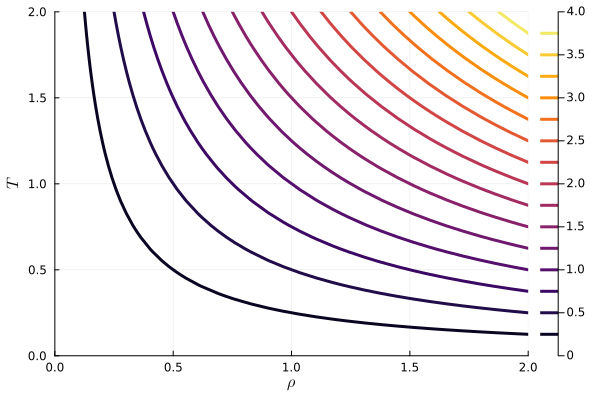

In [2]:
pressure(rho, T) = rho*T

contour(LinRange(0, 2, 30), LinRange(0, 2, 30), pressure, xlabel="\$\\rho\$", ylabel="\$T\$")

# Conservation equations

## Mass

Let $\mathbf u$ be the fluid velocity. The mass flux (mass/time) moving through an area $A$ is

$$ \int_A \rho \mathbf u \cdot \hat{\mathbf n} .$$

If mass is conserved in a volume $V$ with surface $A$, then the total mass inside the volume must evolve as

$$ \int_V \rho_t = \left( \int_V \rho \right)_t = - \underbrace{\int_A \rho\mathbf u \cdot \hat{\mathbf n}}_{\int_V \nabla\cdot (\rho\mathbf u)},$$
where we have applied the divergence theorem. Dropping the integrals over arbitrary volumes, we have the evolution equation for conservation of mass.
$$ \rho_t + \nabla\cdot (\rho \mathbf u) = 0 $$

## Momentum

The momentum $\rho \mathbf u$ has a flux that includes

* convection $\rho \mathbf u \otimes \mathbf u$
  * this is saying that each component of momentum is carried along in the vector velocity field
* pressure $p I$
* viscous $-\boldsymbol\tau$

A similar integral principle leads to the momentum equation

$$ (\rho \mathbf u)_t + \nabla\cdot\big[ \rho \mathbf u \otimes \mathbf u + p I - \boldsymbol \tau \big] = 0 $$

# Simplifications

* Ignore viscous stress tensor $\boldsymbol \tau$
* Ignore energy equation (not yet written) and assume constant temperature
  * $p = a^2 \rho$ where $a$ is the acoustic wave speed

$$\begin{pmatrix} \rho \\ \rho \mathbf u \end{pmatrix}_t + \nabla\cdot \begin{bmatrix}
\rho \mathbf u \\ \rho \mathbf u \otimes \mathbf u + \rho a^2 I \end{bmatrix} = 0 $$

## Linearization

Split each state variable into a mean state and a small fluctuation
* $\rho = \bar\rho + \tilde\rho$
* $u = \bar u + \tilde u$

Let $\widetilde{\rho u} = (\bar\rho + \tilde\rho) (\bar u + \tilde u) - \bar\rho\bar u \approx \tilde \rho \bar u + \bar\rho \tilde u$, where we have dropped the second order term $\tilde \rho\tilde u$ because both are assumed small.

We consider background state $\bar u = 0$ and constant $\bar\rho(x,y,t) = \bar\rho$. Then
$$\begin{pmatrix} \tilde \rho \\ \bar\rho \mathbf{\tilde u} \end{pmatrix}_t + \nabla\cdot \begin{bmatrix}
\bar\rho \mathbf{\tilde u} \\ \tilde \rho a^2 I \end{bmatrix} = 0 $$

# Two forms of acoustic wave equation

Divide the momentum equation through by background density and dropping the tildes yields the standard form.
$$\begin{pmatrix} \rho \\ \mathbf u \end{pmatrix}_t + \nabla\cdot \begin{bmatrix}
\bar\rho \mathbf u \\ \rho \frac{a^2}{\bar\rho} I \end{bmatrix} = 0 .$$

Examine second equation
$$ \frac{a^2}{\bar\rho} \nabla\cdot\big[ \rho I \big] = \frac{a^2}{\bar\rho} \nabla \rho $$
and thus
$$\begin{pmatrix} \rho \\ \mathbf u \end{pmatrix}_t +
\begin{bmatrix} & \bar\rho \nabla\cdot \\
\frac{a^2}{\bar\rho} \nabla & \\
\end{bmatrix}
\begin{pmatrix} \rho \\ \mathbf u \end{pmatrix} = 0.$$


Let's differentiate the first equation,
$$ \rho_{tt} + \bar\rho\nabla\cdot(\mathbf u_t) = 0$$
and substitute in the second equation
$$ \rho_{tt} = a^2 \nabla\cdot(\nabla \rho)$$

* Note: we had to assume these derivatives exist!

We can reduce this to a first order system as

$$\begin{pmatrix} \rho \\ \dot \rho \end{pmatrix}_t + \begin{bmatrix} & -I \\ -a^2 \nabla\cdot\nabla & \end{bmatrix}
\begin{pmatrix} \rho \\ \dot\rho \end{pmatrix} = 0$$

## Question
* How is the problem size different?
* What might we be concerned about in choosing the second formulation?

# Laplacian in periodic domain

In [30]:
function laplacian_matrix(n)
    h = 2 / n
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    wrap(i) = (i + n - 1) % n + 1
    idx(i, j) = (wrap(i)-1)*n + wrap(j)
    stencil_diffuse = [-1, -1, 4, -1, -1] / h^2
    for i in 1:n
        for j in 1:n
            append!(rows, repeat([idx(i,j)], 5))
            append!(cols, [idx(i-1,j), idx(i,j-1), idx(i,j), idx(i+1,j), idx(i,j+1)])
            append!(vals, stencil_diffuse)
        end
    end
    sparse(rows, cols, vals)
end
cond(Matrix(laplacian_matrix(5)))

2.9959163385932148e16

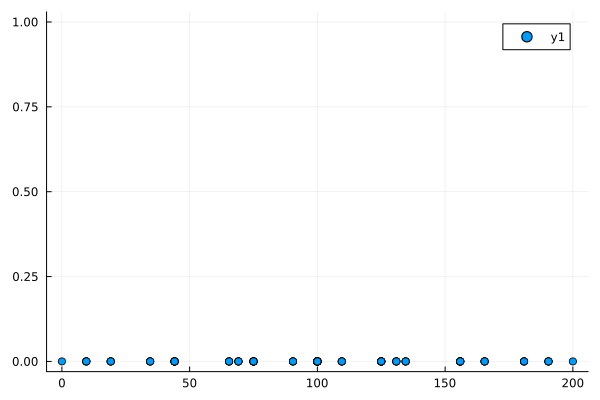

In [31]:
L = laplacian_matrix(10)
ev = eigvals(Matrix(L))
scatter(real(ev), imag(ev))

# Wave operator

$$\begin{pmatrix} \rho \\ \dot \rho \end{pmatrix}_t = \begin{bmatrix} & I \\ a^2 \nabla\cdot\nabla & \end{bmatrix}
\begin{pmatrix} \rho \\ \dot\rho \end{pmatrix}$$

In [32]:
function wave_matrix(n; a=1)
    Z = spzeros(n^2, n^2)
    L = laplacian_matrix(n)
    [Z I; -a^2*L Z]
end
wave_matrix(2)

8×8 SparseMatrixCSC{Float64, Int64} with 16 stored entries:
   ⋅     ⋅     ⋅     ⋅   1.0   ⋅    ⋅    ⋅ 
   ⋅     ⋅     ⋅     ⋅    ⋅   1.0   ⋅    ⋅ 
   ⋅     ⋅     ⋅     ⋅    ⋅    ⋅   1.0   ⋅ 
   ⋅     ⋅     ⋅     ⋅    ⋅    ⋅    ⋅   1.0
 -4.0   2.0   2.0    ⋅    ⋅    ⋅    ⋅    ⋅ 
  2.0  -4.0    ⋅    2.0   ⋅    ⋅    ⋅    ⋅ 
  2.0    ⋅   -4.0   2.0   ⋅    ⋅    ⋅    ⋅ 
   ⋅    2.0   2.0  -4.0   ⋅    ⋅    ⋅    ⋅ 

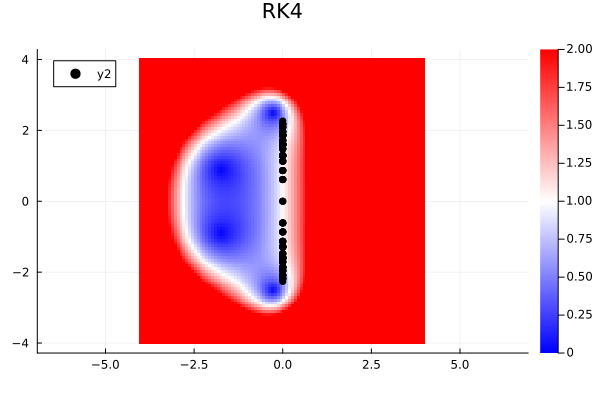

In [33]:
A = wave_matrix(8; a=2) * .1
ev = eigvals(Matrix(A))
plot_stability(z -> rk_stability(z, rk4), "RK4", xlims=(-4, 4), ylims=(-4, 4))
scatter!(real(ev), imag(ev), color=:black)

## Question: would forward Euler work?

# Example 2D wave solver with RK4

In [34]:
n = 20
A = wave_matrix(n)
x = LinRange(-1, 1, n+1)[1:end-1]
y = x
rho0 = vec(exp.(-9*((x .+ 1e-4).^2 .+ y'.^2)))
sol0 = vcat(rho0, zero(rho0))
thist, solhist = ode_rk_explicit((t, sol) -> A * sol, sol0, h=.02)
size(solhist)

(800, 51)

[ Info: Saved animation to /home/jed/cu/numpde-23f/slides/tmp.gif


Plots.AnimatedGif("/home/jed/cu/numpde-23f/slides/tmp.gif")
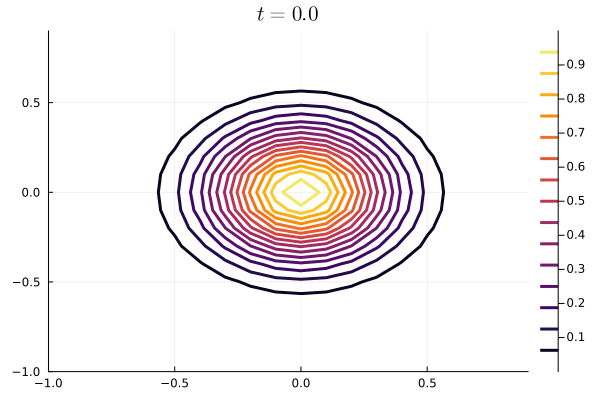

In [8]:
@gif for tstep in 1:length(thist)
    rho = solhist[1:n^2, tstep]
    contour(x, y, reshape(rho, n, n), title="\$ t = $(thist[tstep])\$")
end 

# Accuracy, conservation of mass with RK4

In [42]:
thist, solhist = ode_rk_explicit((t, sol) -> A * sol, sol0, h=.05,
    tfinal=1)

tfinal = thist[end]
M = exp(Matrix(A*tfinal))
sol_exact = M * sol0
sol_final = solhist[:, end]
norm(sol_final - sol_exact)

0.020151117484358525

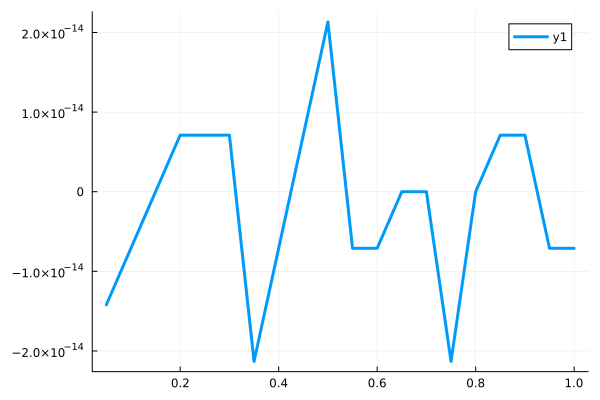

In [43]:
mass = vec(sum(solhist[1:n^2, :], dims=1))
plot(thist[2:end], mass[2:end] .- mass[1])

# Conservation of energy with RK4

## Hamiltonian structure

We can express the total energy for our system as a sum of kinetic and potential energy.

$$H(\rho, \dot\rho) = \underbrace{\frac 1 2 \int_\Omega (\dot\rho)^2}_{\text{kinetic}} + \underbrace{\frac{a^2}{2} \int_\Omega \lVert \nabla \rho \rVert^2}_{\text{potential}}$$

where we identify $\rho$ as a generalized position and $\dot\rho$ as generalized momentum. Hamilton's equations state that the equations of motion are

$$ \begin{pmatrix} \rho \\ \dot\rho \end{pmatrix}_t = \begin{bmatrix}
\frac{\partial H}{\partial \dot\rho} \\
-\frac{\partial H}{\partial \rho}
\end{bmatrix} = \begin{bmatrix}
\dot\rho \\
- a^2 L \rho
\end{bmatrix} $$
where we have used the weak form to associate $\int \nabla v \cdot \nabla u = v^T L u$.

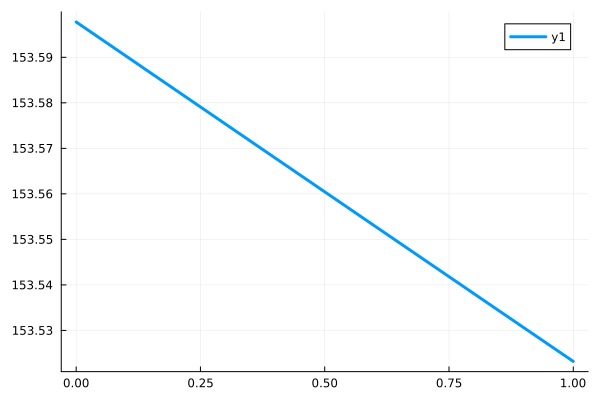

In [11]:
function energy(sol, n)
    L = laplacian_matrix(n)
    rho = sol[1:end÷2]
    rhodot = sol[end÷2+1:end]
    kinetic = .5 * norm(rhodot)^2
    potential = .5 * rho' * L * rho
    kinetic + potential
end
ehist = [energy(solhist[:,i], n) for i in 1:length(thist)]
plot(thist, ehist)

# Velocity Verlet integrator

In [44]:
function wave_verlet(n, u0; tfinal=1., h=0.1)
    L = laplacian_matrix(n)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    irho = 1:n^2
    irhodot = n^2+1:2*n^2
    accel = -L * u[irho]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        u[irho] += h * u[irhodot] + h^2/2 * accel
        accel_next = -L * u[irho]
        u[irhodot] += h/2 * (accel + accel_next)
        accel = accel_next
        t = tnext
        push!(thist, t)
        push!(uhist, copy(u))
    end
    thist, hcat(uhist...)
end

wave_verlet (generic function with 1 method)

[ Info: Saved animation to /home/jed/cu/numpde-23f/slides/tmp.gif


Plots.AnimatedGif("/home/jed/cu/numpde-23f/slides/tmp.gif")
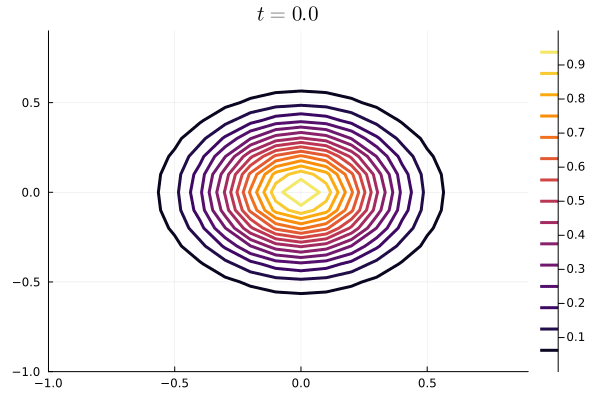

In [45]:
thist, solhist = wave_verlet(n, sol0, h=.04)
@gif for tstep in 1:length(thist)
    rho = solhist[1:n^2, tstep]
    contour(x, y, reshape(rho, n, n), title="\$ t = $(thist[tstep])\$")
end

# Accuracy and conservation for Verlet

norm(sol_final - sol_exact) = 6.86250099252763


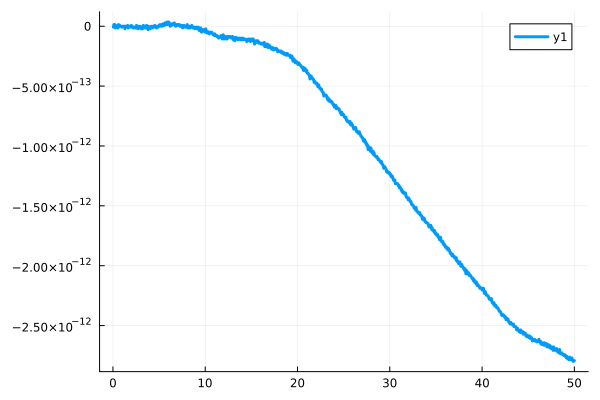

In [46]:
thist, solhist = wave_verlet(n, sol0, h=.05, tfinal=50)
tfinal = thist[end]
M = exp(Matrix(A*tfinal))
sol_exact = M * sol0
sol_final = solhist[:, end]
@show norm(sol_final - sol_exact)

mass = vec(sum(solhist[1:n^2, :], dims=1))
plot(thist[2:end], mass[2:end] .- mass[1])

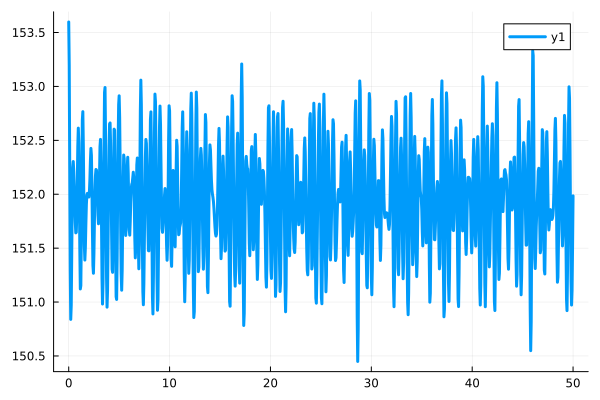

In [15]:
ehist = [energy(solhist[:,i], n) for i in 1:length(thist)]
plot(thist, ehist)

# Notes on time integrators

* We need stability on the imaginary axis for our discretization (and the physical system)
* If the model is dissipative (e.g., we didn't make the zero-viscosity assumption), then we need stability in the left half plane.
* The split form $\rho, \rho\mathbf u$ form is usually used with (nonlinear) upwinding, and thus will have dissipation.

## Runge-Kutta methods
* Easy to use, stability region designed for spatial discretization
* Energy drift generally present

## Verlet/leapfrog/Newmark and symplectic integrators

* These preserve the "geometry of the Hamiltonian"
  * energy is not exactly conserved, but it doesn't drift over time
  * such methods are called "symplectic integrators"
* May not have stability away from the imaginary axis (for dissipation)
* Most require a generalized position/momentum split, "canonical variables"

# Start with advection-diffusion operator in 2D

* Eliminate Dirichlet boundary conditions around all sides

In [16]:
function advdiff_matrix(n; kappa=1, wind=[0, 0])
    h = 2 / (n + 1)
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    idx((i, j),) = (i-1)*n + j
    in_domain((i, j),) = 1 <= i <= n && 1 <= j <= n
    stencil_advect = [-wind[1], -wind[2], 0, wind[1], wind[2]] / h
    stencil_diffuse = [-1, -1, 4, -1, -1] * kappa / h^2
    stencil = stencil_advect + stencil_diffuse
    for i in 1:n
        for j in 1:n
            neighbors = [(i-1, j), (i, j-1), (i, j), (i+1, j), (i, j+1)]
            mask = in_domain.(neighbors)
            append!(rows, idx.(repeat([(i,j)], 5))[mask])
            append!(cols, idx.(neighbors)[mask])
            append!(vals, stencil[mask])
        end
    end
    sparse(rows, cols, vals)
end

advdiff_matrix (generic function with 1 method)

norm(A - A') = 0.0


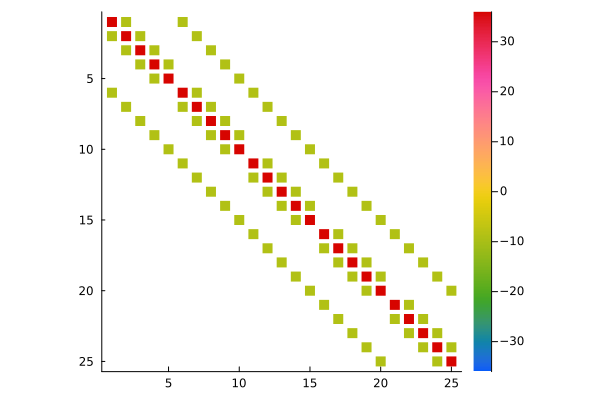

In [17]:
A = advdiff_matrix(5, wind=[0, 0])
@show norm(A - A')
my_spy(A)

# Gaussian elimination and Cholesky

## $LU = A$
Given a $2\times 2$ block matrix, the algorithm proceeds as
\begin{split}
  \begin{bmatrix} A & B \\ C & D \end{bmatrix} &=
  \begin{bmatrix} L_A & \\ C U_A^{-1} & 1 \end{bmatrix}
  \begin{bmatrix} U_A & L_A^{-1} B \\ & S \end{bmatrix}
\end{split}
where $L_A U_A = A$ and
$$S = D - C \underbrace{U_A^{-1} L_A^{-1}}_{A^{-1}} B .$$

## Cholesky $L L^T = A$
\begin{split}
  \begin{bmatrix} A & B^T \\ B & D \end{bmatrix} &=
  \begin{bmatrix} L_A & \\ B L_A^{-T} & 1 \end{bmatrix}
  \begin{bmatrix} L_A^T & L_A^{-1} B^T \\ & S \end{bmatrix}
\end{split}
where $L_A L_A^T = A$ and
$$ S = D - B \underbrace{L_A^{-T} L_A^{-1}}_{A^{-1}} B^T .$$

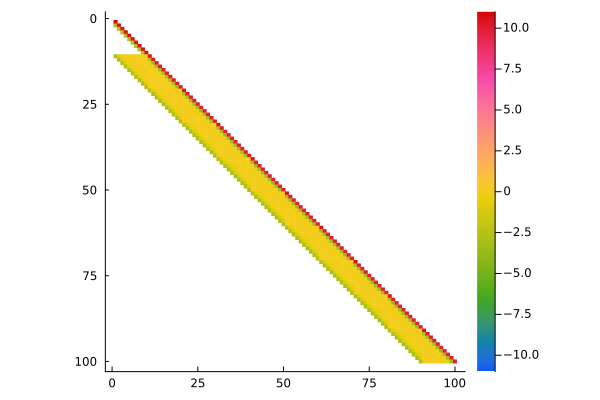

In [18]:
A = advdiff_matrix(10)
N = size(A, 1)
ch = cholesky(A, perm=1:N)
my_spy(A)
my_spy(sparse(ch.L))

# Cost of a banded solve

Consider an $N\times N$ matrix with bandwidth $b$, $1 \le b \le N$.

* Work one row at a time
* Each row/column of panel has $b$ nonzeros
* Schur update affects $b\times b$ sub-matrix
* Total compute cost $N b^2$
* Storage cost $N b$

## Question
* What bandwidth $b$ is needed for an $N = n\times n \times n$ cube in 3 dimensions?
* What is the memory cost?
* What is the compute cost?

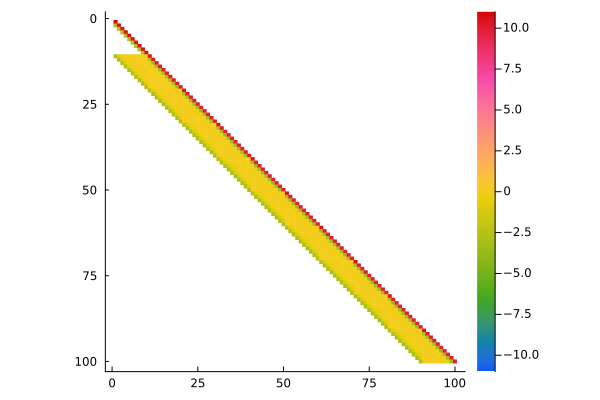

In [19]:
my_spy(sparse(ch.L))

# Different orderings

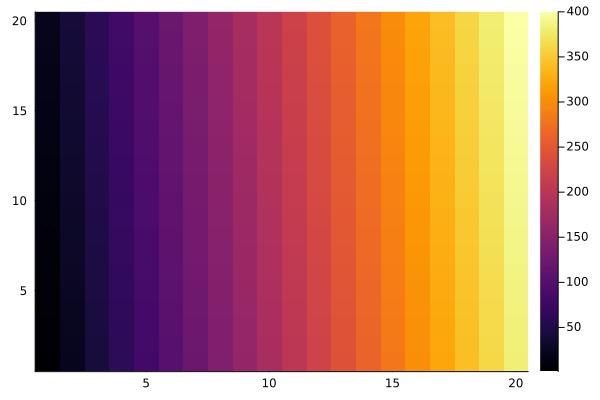

In [20]:
n = 20
A = advdiff_matrix(n)
heatmap(reshape(1:n^2, n, n))

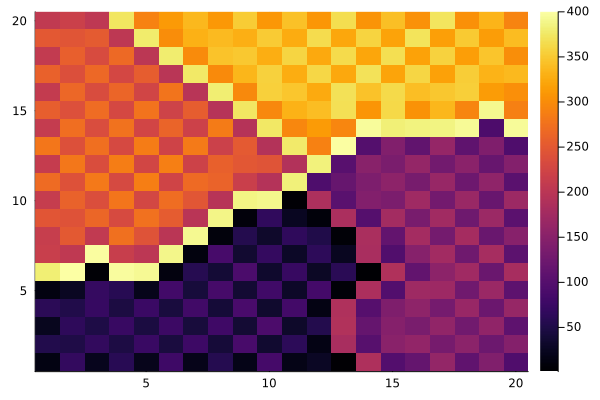

In [21]:
import Metis
perm, iperm = Metis.permutation(A)
heatmap(reshape(iperm, n, n))

In [22]:
cholesky(A, perm=1:n^2)

SparseArrays.CHOLMOD.Factor{Float64}
type:    LLt
method:  simplicial
maxnnz:  8019
nnz:     8019
success: true


In [23]:
cholesky(A, perm=Vector{Int64}(perm))

SparseArrays.CHOLMOD.Factor{Float64}
type:    LLt
method:  simplicial
maxnnz:  4031
nnz:     4031
success: true


# Cholesky factors in nested dissection

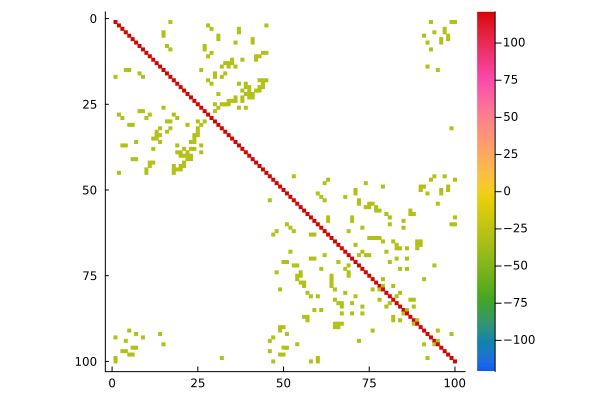

In [24]:
n = 10
A = advdiff_matrix(n)
perm, iperm = Metis.permutation(A)
my_spy(A[perm, perm])

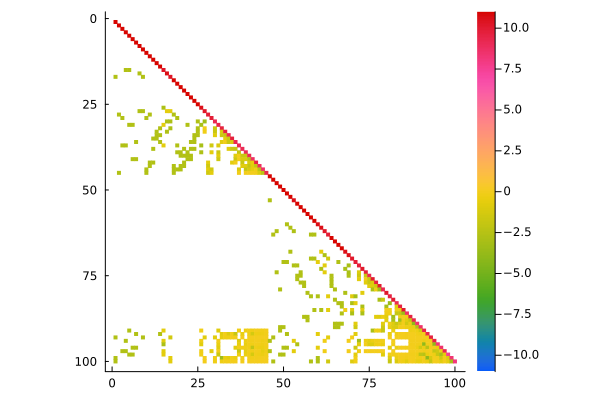

In [25]:
ch = cholesky(A, perm=Vector{Int64}(perm))
my_spy(sparse(ch.L))

* The dense blocks in factor $L$ are "supernodes"
* They correspond to "vertex separators" in the ordering

# Cost in nested dissection

* Cost is dominated by dense factorization of the largest supernode
* Its size comes from the vertex separator size

## 2D square

* $N = n^2$ dofs
* Vertex separator of size $n$
* Compute cost $v^3 = N^{3/2}$
* Storage cost $N \log N$

## 3D Cube

* $N = n^3$ dofs
* Vertex separator of size $v = n^2$
* Compute cost $v^3 = n^6 = N^2$
* Storage cost $v^2 = n^4 = N^{4/3}$

## Questions

1. How much does the cost change if we switch from Dirichlet to periodic boundary conditions in 2D?
2. How much does the cost change if we move from 5-point stencil ($O(h^2)$ accuracy) to 9-point "star" stencil ($O(h^4)$ accuracy)?
3. Would you rather solve a 3D problem on a $10\times 10\times 10000$ grid or $100\times 100 \times 100$?

# Test our intuition

In [26]:
n = 50
A_dirichlet = advdiff_matrix(n)
perm, iperm = Metis.permutation(A_dirichlet)
cholesky(A_dirichlet, perm=Vector{Int64}(perm))
#cholesky(A_dirichlet)

SparseArrays.CHOLMOD.Factor{Float64}
type:    LLt
method:  simplicial
maxnnz:  40203
nnz:     40203
success: true


In [27]:
A_periodic = laplacian_matrix(n) + 1e-10*I
perm, iperm = Metis.permutation(A_periodic)
cholesky(A_periodic, perm=Vector{Int64}(perm))
#cholesky(A_periodic)

SparseArrays.CHOLMOD.Factor{Float64}
type:    LLt
method:  supernodal
maxnnz:  0
nnz:     60083
success: true


# How expensive how fast?

Suppose we have a second order accurate method in 3D.

In [28]:
n = 2. .^ (2:13)
N = n.^3
error = (50 ./ n) .^ 2
seconds = 1e-10 * N.^2
hours = seconds / 3600
cloud_dollars = 3 * hours
kW_hours = 0.2 * hours
barrel_of_oil = kW_hours / 1700
kg_CO2 = kW_hours * 0.709
;

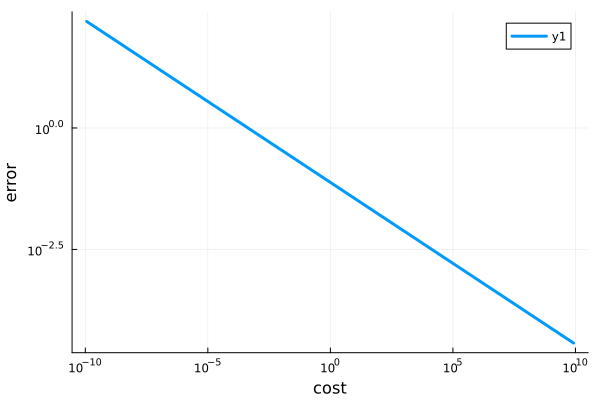

In [29]:
cost = hours
plot(cost, error, xlabel="cost", ylabel="error", xscale=:log10, yscale=:log10)

* [Barrel of oil equivalent](https://en.wikipedia.org/wiki/Barrel_of_oil_equivalent)
* [Electricity emission factor](https://www.epa.gov/energy/greenhouse-gases-equivalencies-calculator-calculations-and-references)

# Outlook on sparse direct solvers

* Sparse direct works well for 2D and almost-2D problems to medium large sizes
  * High order FD methods make sparse direct cry
  * High order finite element are okay, but [not high-continuity splines](https://doi.org/10.1016/j.cma.2011.11.002)
  * Almost-2D includes a lot of industrial solid mechanics applications
    * The body of a car, the frame of an airplane
* Sparse direct is rarely usable in "fully 3D" problems
  * "thick" structures
    * soil mechanics, hydrology, building foundations, bones, tires
  * fluid mechanics
    * aerodynamics, heating/cooling systems, atmosphere/ocean
* Setup cost (factorization) is much more expensive than solve
  * Amortize cost in time-dependent problems
    * Rosenbrock methods: factorization reused across stages
    * "lag" Jacobian in Newton (results in "modified Newton")
    * "lag" preconditioner with matrix-free iterative methods (Sundials, PETSc)
  * Factorization pays off if you have many right hand sides

# Iterative solvers

* Less reliable, more leaky abstraction
* More sensitive to problem formulation
* Slower for small problems
* Several different strategies, each with tuning knobs
* Accuracy tolerances needed

## $O(N)$ solvers available for many important problems
* High-order discretization *can* be okay